In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

This notebook compares simualtions done with an older and a newer version of nexus. This is because a large change in the number of photons seen by the PMTs occured between the newer and older versions, without an obvious reason. These simulations use a NEXT-100 like geometry, with 1.3mm sipms at a 15mm pitch, including the teflon in front of the tracking plane.

This notebook also compares these numbers to estimated numbers using the physics and geometry of the detector. These estimation in past studies have shown to be very different than the simulation numbers. 

- For the old, new, and estimated numbers compare:
     - Number of ionization electrons
     - Number of scintillation photons
     - Number of EL photons
     - Number of photons hitting SiPMs
         - Charge seen by the SiPMs
     - Number of photons hitting PMTs
         - Charge seen by the PMTs

In [2]:
# For all events
def GetIonizationElectrons(particles_df):
    """ 
    Number of ionization electrons in one event.
    """
    return particles_df[particles_df['particle_name']=='ie-'].groupby('event_id').size()

def GetSciPhotons(photons_df):
    """
    Number of scintillation photons in one event.
    """
    return photons_df[photons_df.creator_proc=='Scintillation'].groupby('event_id').size()

def GetELPhotons(photons_df):
    """
    Number of photons produced by electroluminescence in one event.
    """
    return photons_df[photons_df.creator_proc=='Electroluminescence'].groupby('event_id').size()

def GetSiPMHits(photons_df):
    """
    Number of photons hitting the TP_SIPM_SENSAREA in one event, considered
    as photons hitting the SiPMs.
    """
    return photons_df[photons_df.final_volume=='TP_SiPM_SENSAREA'].groupby('event_id').size()

def GetPMTPhotons(trans_photons_df):
    """
    Number of photons reaching the area around the PMTs in one event.
    """
    tp_photons = trans_photons_df[trans_photons_df.final_z > 1400]
    tp_photons = tp_photons[tp_photons.final_z < 1500]
    return tp_photons.groupby('event_id').size()

def GetPMTHits(trans_photons_df):
    """
    Number of photons hitting the PMT sensitive area, which are the
    photons with the final process 'Transportation' in the final
    volume 'PMT_PHOTOCATHODE'.
    """
    return trans_photons_df[trans_photons_df.final_volume=='PMT_PHOTOCATHODE'].groupby('event_id').size()

def GetSiPMCharge(sns_response_sorted):
    """
    Total charge (photoelectrons) seen by the SiPMs in one event.
    """
    sipm_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] >999]
    sipm_response_evts = sipm_response.groupby('event_id')
    charges = sipm_response_evts.agg({"charge":"sum"})
    return charges.charge

def GetPMTCharge(sns_response_sorted):
    """
    Total charge (photoelectrons) seen by the PMTs in one event.
    """
    pmt_response = sns_response_sorted.loc[sns_response_sorted["sensor_id"] < 999]
    pmt_response_evts = pmt_response.groupby('event_id')
    charges = pmt_response_evts.agg({"charge":"sum"})
    return charges.charge

# Load old and new file

In [4]:
old_file = '/Users/taylorcontreras/Development/Research/trackingplane/data/test/flex.kr83m.s1.3mmp15mm_old.nexus.h5'
old_sns_response = pd.read_hdf(old_file, 'MC/sns_response')
old_hits = pd.read_hdf(old_file, 'MC/hits')
old_particles = pd.read_hdf(old_file, 'MC/particles')

In [27]:
new_file = '/Users/taylorcontreras/Development/Research/trackingplane/data/test/flex.kr83m.s1.3mmp15mm_new.nexus.h5'
new_sns_response = pd.read_hdf(new_file, 'MC/sns_response')
new_hits = pd.read_hdf(new_file, 'MC/hits')
new_particles = pd.read_hdf(new_file, 'MC/particles')

In [50]:
old2_file = '/Users/taylorcontreras/Development/Research/trackingplane/data/test/flex.kr83m.s1.3mmp15mm_old2.nexus.h5'
old2_sns_response = pd.read_hdf(old2_file, 'MC/sns_response')
old2_hits = pd.read_hdf(old2_file, 'MC/hits')
old2_particles = pd.read_hdf(old2_file, 'MC/particles')

# Understanding the Output

This section carefully goes through the old simulation, to understand the output.

In [5]:
old_sns_response.groupby('event_id').count()

,sensor_id,time_bin,charge
event_id,,,
0,12039,12039,12039
1,10589,10589,10589
2,12956,12956,12956
3,10803,10803,10803
4,13439,13439,13439
5,11896,11896,11896
6,9393,9393,9393
7,12261,12261,12261
8,12603,12603,12603


In [46]:
old_hits.groupby('event_id').count()

,x,y,z,time,energy,label,particle_id,hit_id
event_id,,,,,,,,
0,54,54,54,54,54,54,54,54
1,80,80,80,80,80,80,80,80
2,62,62,62,62,62,62,62,62
3,62,62,62,62,62,62,62,62
4,63,63,63,63,63,63,63,63
5,72,72,72,72,72,72,72,72
6,72,72,72,72,72,72,72,72
7,54,54,54,54,54,54,54,54
8,58,58,58,58,58,58,58,58


In [7]:
old_particles.columns #.groupby('event_id').count()

Index(['event_id', 'particle_id', 'particle_name', 'primary', 'mother_id',
       'initial_x', 'initial_y', 'initial_z', 'initial_t', 'final_x',
       'final_y', 'final_z', 'final_t', 'initial_volume', 'final_volume',
       'initial_momentum_x', 'initial_momentum_y', 'initial_momentum_z',
       'final_momentum_x', 'final_momentum_y', 'final_momentum_z',
       'kin_energy', 'length', 'creator_proc', 'final_proc'],
      dtype='object')

In [8]:
old_sns_response[old_sns_response.sensor_id<99].sensor_id.max()

59

In [9]:
old_particles[['creator_proc']].drop_duplicates()

,creator_proc
0,Scintillation
2,OpWLS
10,Electroluminescence
1435,Clustering
379552,none
571278,phot
3067292,compt


In [10]:
old_particles[['final_proc']].drop_duplicates()

,final_proc
0,OpWLS
2,OpAbsorption
4,Transportation
1435,Drift
379552,Scintillation
563216,phot
3026995,StepLimiter


In [11]:
old_particles[['final_volume']].drop_duplicates()

,final_volume
0,LIGHT_TUBE_WLS
2,GATE
4,LIGHT_TUBE
7,EP_COPPER
10,ANODE
11,TP_TEFLON_WLS
30,PMT_PHOTOCATHODE
32,TP_TEFLON
36,ICS
46,TP_SiPM_CASE


In [12]:
GetIonizationElectrons(old_particles)

event_id
0    1826
1    1836
2    1854
3    1869
4    1861
5    1880
6    1863
7    1859
8    1837
9    1862
dtype: int64

In [13]:
GetSciPhotons(old_particles)

event_id
0    1020
1    1010
2    1057
3    1057
4    1063
5    1051
6    1067
7    1085
8    1069
9    1054
dtype: int64

In [14]:
GetELPhotons(old_particles)

event_id
0    1788763
1    1795968
2    1814288
3    1832427
4    1823028
5    1840267
6    1576513
7    1821911
8    1798822
9    1825100
dtype: int64

In [15]:
GetSiPMHits(old_particles)

event_id
0    2644
1    2339
2    2518
3    2630
4    2638
5    2685
6    1572
7    2526
8    2601
9    2670
dtype: int64

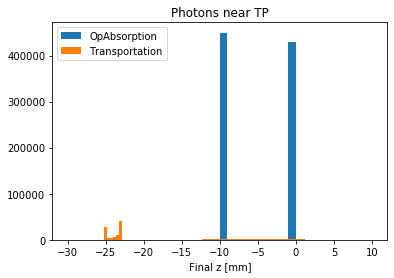

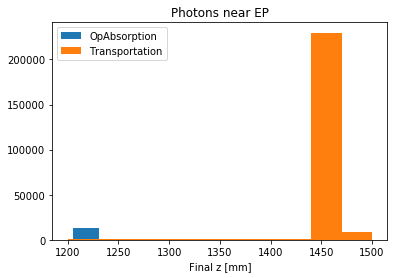

In [16]:
# Trying to understand final processes 
event0 = old_particles[old_particles['event_id']==0]
photons_evt0 = event0[event0['particle_name']=='opticalphoton']
abs_photons = photons_evt0[photons_evt0.final_proc=='OpAbsorption']
plt.hist(abs_photons[abs_photons.final_z < 10].final_z, label='OpAbsorption')

abs_photons = photons_evt0[photons_evt0.final_proc=='Transportation']
this = abs_photons[abs_photons.final_z < 10]
plt.hist(this[this.final_z > -30].final_z, label='Transportation', bins=100)
plt.title('Photons near TP')
plt.xlabel('Final z [mm]')
plt.legend()
plt.show()

abs_photons = photons_evt0[photons_evt0.final_proc=='OpAbsorption']
plt.hist(abs_photons[abs_photons.final_z > 1200].final_z, label='OpAbsorption')

abs_photons = photons_evt0[photons_evt0.final_proc=='Transportation']
this = abs_photons[abs_photons.final_z > 1200]
plt.hist(this[this.final_z < 1500].final_z, label='Transportation')
plt.title('Photons near EP')
plt.xlabel('Final z [mm]')
plt.legend()
plt.show()

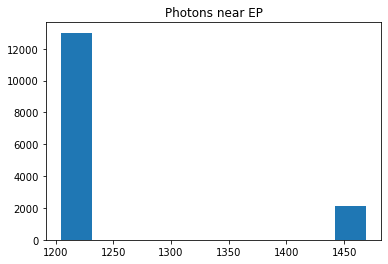

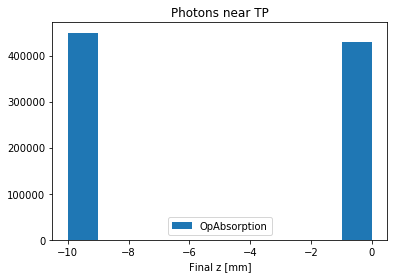

In [17]:
abs_photons = photons_evt0[photons_evt0.final_proc=='OpAbsorption']
plt.hist(abs_photons[abs_photons.final_z > 1100].final_z, label='OpAbsorption')
plt.title('Photons near EP')
plt.show()

abs_photons = photons_evt0[photons_evt0.final_proc=='OpAbsorption']
plt.hist(abs_photons[abs_photons.final_z < 10].final_z, label='OpAbsorption')
plt.title('Photons near TP')
plt.xlabel('Final z [mm]')
plt.legend()
plt.show()

This tells me the OpAbsorption is not the final process for photons being absorbed by a sensitive material like I thought. OpAbsorption seems to mostly be for photons hitting the gate, anode, and cathode meshes, most likely because these have a set optical properties unlike most other materials. There are some OpAbsorption at the PMTs, probably also from things with optical props like the fused silica. Note that the active length is 1204.95mm, pmt z position is 1459.55mm. this makes me confident that photons collected by sensitive dectors have the final process 'Transportation'. 

In [18]:
abs_photons = photons_evt0[photons_evt0.final_proc=='Transportation']
tp_photons = abs_photons[abs_photons.final_z > 1400]
tp_photons = tp_photons[tp_photons.final_z < 1500]
tp_photons.final_volume.drop_duplicates().to_list()

['EP_COPPER', 'PMT_PHOTOCATHODE', 'PMT_GAS', 'PMT', 'ICS', 'LIGHT_TUBE']

In [19]:
tp_photons.creator_proc.drop_duplicates()

7            Scintillation
28                   OpWLS
204    Electroluminescence
Name: creator_proc, dtype: object

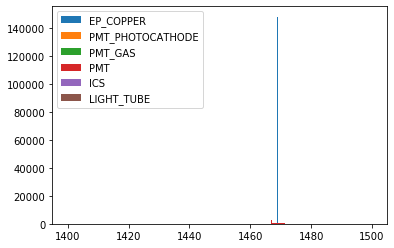

In [20]:
for volume in tp_photons.final_volume.drop_duplicates().to_list():
    plt.hist(tp_photons[tp_photons.final_volume==volume].final_z, label=volume, bins=100)
plt.legend()
plt.show()

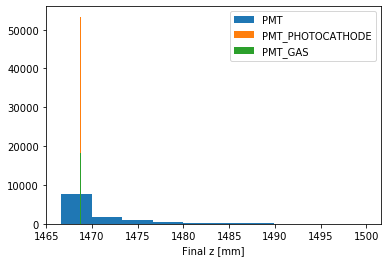

In [21]:
plt.hist(tp_photons[tp_photons.final_volume=='PMT'].final_z, label='PMT')
plt.hist(tp_photons[tp_photons.final_volume=='PMT_PHOTOCATHODE'].final_z, label='PMT_PHOTOCATHODE')
plt.hist(tp_photons[tp_photons.final_volume=='PMT_GAS'].final_z, label='PMT_GAS')
plt.legend()
plt.xlabel('Final z [mm]')
plt.show()

So the PMTs only have optical properties when a photon hits the front, goes through those layers and then hits the photocathode. So any photons hitting the outside of the PMT will result in the final volume ‘PMT’. The ‘PMT_PHOTOCATHODE’ peak is because of the fact that all photons are stopped right at the surface. The ‘PMT_GAS’ is probably photons going through the fron to the PMT but missing the photocathode which is smaller and instead hitting the gas which has no optical properties so they are stopped immediately

 This mostly makes sense becuase the PMT is the mother volume of the actual PMT nexus volumes. So photons could get stopped by materials in the PMT. The PMT_PHOTOCATHODE is the actual sensitive detector volume, so the spike there also makes sense. Not sure about the spike for PMT_GAS.

## Estimation Functions

In [54]:
# Constants in all cases
E_qbb = 2400. # keV
E_kr = 41.5 # keV
dEdx_qbb_blob = 20 # keV/cm
dEdx_qbb_track = 7 # keV/cm
dEdx_kr = 20 # no idea if this is true or not...
W_sci = 39.2
W_i = 21.9

def N_i(E, W=W_i):
    """
    Returns number of ionization electrons released 
    in a material with an ionization energy of W_i
    with an energy of E.
    
    Input: 
        E - energy in keV
        W_i - ionization energy in eV, default to GXe
    """
    return E*1000./W

def old2_EL_yield(d_EL, Efield, P):
    """
    Returns the EL yield calculated in the version of nexus
    from Nov 2020.
    """
    a = 140. 
    b = 116.
    
    ELyield = (a * Efield/P - b) * P

    return ELyield

def EL_yield(d_EL, Efield, P):
    """
    Returns the EL yeild, the number of photons per ionization
    electron crossing the EL gap.
    Reference: E.D.C.Freitas 2010, 'Secondary scintillation 
        yield in high-pressure xenon gas for neutrinoless double 
        beta decay  search'
        
    Input: d_EL - length of EL gap [mm], 
           Efield - electric field [kV/cm]
           P - pressure [bar]
    """
    b = 116.
    a = 140.
    if P >= 8.:
        a = 170.
    elif P >= 6.:
        a = 161.
    elif P >= 5.:
        a = 151.
    elif P >= 4.:
        a = 142.
    elif P >= 2.:
        a = 141.
        
    ELyield = (a*Efield/P - b) * P*d_EL/10.
    
    return ELyield

def SAF_SiPM(s, d_EL, d_A, sipm_width=2.):
    """
    Solid angle fraction of a SiPM on 
    the tracking plane.
    Input: s - size of SiPM [mm]
           d_EL - length of EL gap [mm]
           d_A - distance between anode and SiPMs [mm]
    """
    d = d_EL/2. + d_A - sipm_width
    return SAF_square(s, d)

def SAF_square(s, d):
    """
    Solid angle fraction of square plane a distance
    d from the source
    Reference: https://vixra.org/pdf/2001.0603v1.pdf
    
    Input: s - size of SiPM [mm]
           d - distance [mm]
    """
    num = s**2.
    denom = 4.*d**2. * np.sqrt(1. + 2.*s**2./(4.*d**2.))
    return (1./np.pi) * np.arctan( num / denom)

def SAF_Plane(r_TP, d_EL, d_A):
    """
    Solid angle fraction of the circular plane a distance 
    d_EL+d_A from the source.
    
    Input: r_TP - radius of tracking plane [mm]
           d_EL - length of EL gap [mm]
           d_A - distance between anode and SiPMs [mm]
    """
    return 2*np.pi * (1/(4*np.pi)) * (1 - ((d_EL+d_A)/2.)/(np.sqrt(r_TP**2. + ((d_EL+d_A)/2.)**2.)))

def Coverage(r_TP, s, N_sipms):
    """
    Coverage of tracking plane
    
    Input: r_TP - radius of tracking plane [mm]
           s - size of SiPM [mm]
           N_sipms - number of SiPMs [mm]
    """
    return s**2. * N_sipms / (np.pi * r_TP**2.)

def N_d(E, eta, epsilon, f):
    """
    Returns the number of photons detected
    
    Inputs: E - energy of event [keV]
            eta - gain of EL gap
            epsilon - efficiencies, 
            f - fraction of light to planes (Solid angle fraction * Coverage)
    """
    return N_i(E) * eta * epsilon * f

def dN_dt(dE_dx, v_d, eta, epsilon, f_sipm):
    """
    Returns the number of photons detected
    
    Inputs: dE_dx - energy deposition [keV/mm]
            v_d - drift velocity [mm/us]
            eta - gain of EL gap
            epsilon - efficiencies, 
            f_sipm - fraction of light to center most SiPM
    """
    return N_i(dE_dx) * v_d * eta * epsilon * f_sipm

## Comparing numbers between old, new, and estimated for a single event

In [24]:
old_photons = old_particles[old_particles['particle_name']=='opticalphoton']
old_trans_photons = old_photons[old_photons.final_proc=='Transportation']
old_sns_response_sorted = old_sns_response.sort_values(by=['sensor_id'])

In [25]:
old_stats_dict = {'Ionization Electrons':GetIonizationElectrons(old_particles), 
                  'Scintillation Photons':GetSciPhotons(old_photons),
                  'EL Photons': GetELPhotons(old_photons),
                  'SiPM Hits': GetSiPMHits(old_trans_photons),
                  'PMT Hits': GetPMTHits(old_trans_photons),
                  'SiPM Charge': GetSiPMCharge(old_sns_response_sorted),
                  'PMT Charge': GetPMTCharge(old_sns_response_sorted)}

In [28]:
new_photons = new_particles[new_particles['particle_name']=='opticalphoton']
new_trans_photons = new_photons[new_photons.final_proc=='Transportation']
new_sns_response_sorted = new_sns_response.sort_values(by=['sensor_id'])

In [29]:
new_file = '/Users/taylorcontreras/Development/Research/trackingplane/data/test/flex.kr83m.s1.3mmp15mm_new.nexus.h5'
new_sns_response = pd.read_hdf(new_file, 'MC/sns_response')
new_particles = pd.read_hdf(new_file, 'MC/particles')
new_stats_dict = {'Ionization Electrons':GetIonizationElectrons(new_particles), 
                  'Scintillation Photons':GetSciPhotons(new_photons),
                  'EL Photons': GetELPhotons(new_photons),
                  'SiPM Hits': GetSiPMHits(new_trans_photons),
                  'PMT Hits': GetPMTHits(new_trans_photons),
                  'SiPM Charge': GetSiPMCharge(new_sns_response_sorted),
                  'PMT Charge': GetPMTCharge(new_sns_response_sorted)}

In [51]:
old2_photons = old2_particles[old2_particles['particle_name']=='opticalphoton']
old2_trans_photons = old2_photons[old2_photons.final_proc=='Transportation']
old2_sns_response_sorted = old2_sns_response.sort_values(by=['sensor_id'])

In [52]:
old2_stats_dict = {'Ionization Electrons':GetIonizationElectrons(old2_particles), 
                  'Scintillation Photons':GetSciPhotons(old2_photons),
                  'EL Photons': GetELPhotons(old2_photons),
                  'SiPM Hits': GetSiPMHits(old2_trans_photons),
                  'PMT Hits': GetPMTHits(old2_trans_photons),
                  'SiPM Charge': GetSiPMCharge(old2_sns_response_sorted),
                  'PMT Charge': GetPMTCharge(old2_sns_response_sorted)}

In [47]:
d_EL = 10. # mm
d_A = 15. # mm
d_active = 1204.95 # mm
Efield = 16. # kV/cm
P = 15 # bar
elyield = EL_yield(d_EL, Efield, P)
r_TP = 984./2. # mm
C_tp = 0.006 # 1.3mm sipms, 15mm pitch
C_ep = .3
sipm_width = 2. # mm
pmt_eff = ((old_stats_dict['PMT Charge'].mean() / old_stats_dict['PMT Hits'].mean()) + 
                  (new_stats_dict['PMT Charge'].mean() / new_stats_dict['PMT Hits'].mean()))/2.
sipm_eff = ((old_stats_dict['SiPM Charge'].mean() / old_stats_dict['SiPM Hits'].mean()) + 
                  (new_stats_dict['SiPM Charge'].mean() / new_stats_dict['SiPM Hits'].mean()))/2.
transp_gate = .88
transp_anode = .88
transp_cathode = .98
eff_tpb = 0.5
est_sipm_signal = (N_i(E_kr) * elyield * SAF_Plane(r_TP, d_EL, d_A-sipm_width) * C_tp *
                    sipm_eff * transp_gate * transp_anode * eff_tpb)
est_pmt_signal = (N_i(E_kr) * elyield * SAF_Plane(r_TP, d_EL+d_active, d_A-sipm_width) *
                    C_ep * pmt_eff * transp_gate * transp_anode * transp_cathode)
est_stats_dict = {'Ionization Electrons': N_i(E_kr), 
                  'Scintillation Photons': N_i(E_kr, W_sci),
                  'EL Photons': N_i(E_kr) * elyield,
                  'SiPM Hits': est_sipm_signal / sipm_eff,
                  'PMT Hits': est_pmt_signal / pmt_eff,
                  'SiPM Charge': est_sipm_signal,
                  'PMT Charge': est_pmt_signal}

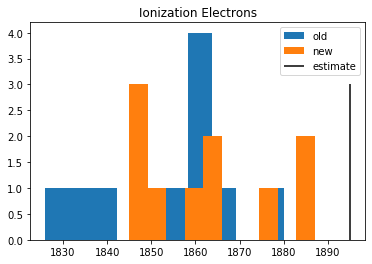

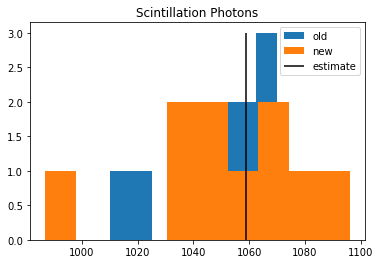

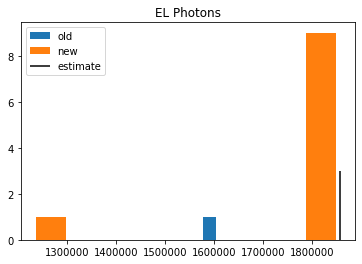

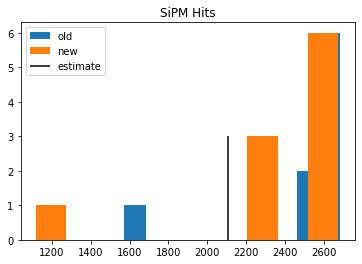

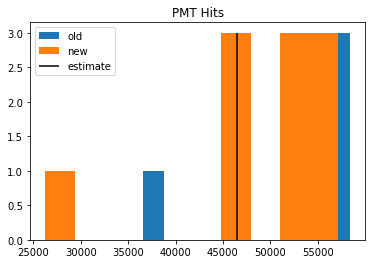

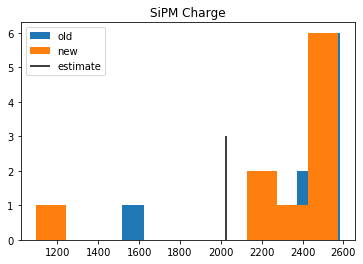

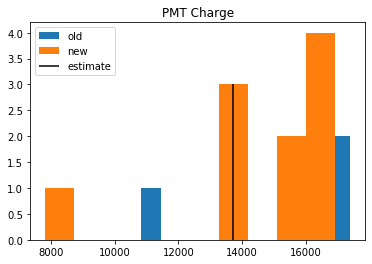

In [48]:
for key in old_stats_dict:
    plt.hist(old_stats_dict[key], label='old')
    plt.hist(new_stats_dict[key], label='new')
    plt.vlines(est_stats_dict[key], 0, 3, label='estimate')
    plt.title(key)
    plt.legend()
    plt.show()

In [53]:
for key in old_stats_dict:
    print(key + ': ')
    print('    old = '+str(old_stats_dict[key].mean())
          +', old2 = '+str(old2_stats_dict[key].mean())
          +', new = '+str(new_stats_dict[key].mean())
          +', est = '+str(est_stats_dict[key]))

Ionization Electrons: 
    old = 1854.7, old2 = 1856.4, new = 1862.3, est = 1894.9771689497718
Scintillation Photons: 
    old = 1053.3, old2 = 1063.7, new = 1053.2, est = 1058.673469387755
EL Photons: 
    old = 1791708.7, old2 = 924318.2, new = 1765908.5, est = 1857077.6255707769
SiPM Hits: 
    old = 2482.3, old2 = 1218.0, new = 2380.7, est = 2106.7732157936534
PMT Hits: 
    old = 52935.9, old2 = 26027.1, new = 49080.5, est = 46432.692800277655
SiPM Charge: 
    old = 2384.7, old2 = 1170.4, new = 2290.8, est = 2025.5777790768034
PMT Charge: 
    old = 15616.1, old2 = 7716.3, new = 14538.3, est = 13725.818415892356


In [56]:
EL_yield(d_EL, Efield, P), old2_EL_yield(d_EL, Efield, P)

(980.0000000000002, 500.0000000000001)

So now all the componets match fairly well, which does not match the results I preseneted in the collaboration meeting. So I went back and compared how I made those plots and remade them. Everything looked the same, so I looked at the actual simulation and found that I made an error with the s1.3mmp15mm and s1.3mmp7mm teflon simulations where I used 8mm teflon hole diameters instead of 5mm. So now the results from the collaboration meeting make more sense, because I was accidently using such a large teflon hole that many photons where lost when they hit the kapton board. 

On a positive note, through this I found that the ELyield needed to be updated, the efficiencies of the TPB and gates, and efficiency of the PMTs needed to be added, making the total photons number roughly match.

## Charge per time bin

This will be a bit difficult with krypton events since they are not tracks so I can't get the dN/dt in the same way, but the Qbb events would take a reeeeeally long time to make save all the output so I don't think its a good idea. 

In [45]:
old_sipm_response = old_sns_response_sorted.loc[old_sns_response_sorted["sensor_id"] >999]
old_sipms_max = old_sipm_response.groupby('event_id').apply(lambda grp: np.max(grp.charge))

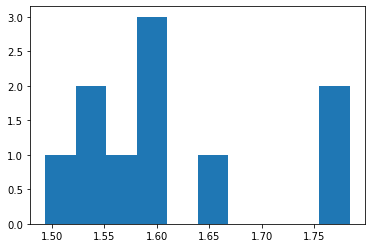

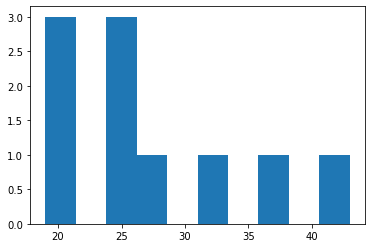

In [44]:
plt.hist(old_sipms_mean)
plt.show()

plt.hist(old_sipms_max)
plt.show()